In [1]:
import flwr as fl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import uuid
from datetime import datetime
import os
from PIL import Image
import cv2
from skimage.metrics import structural_similarity as ssim
import torchvision.transforms.functional as TF

DEVICE = torch.device("cuda")  #"cuda" or "cpu"
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.2.2+cu121 and Flower 1.8.0


In [2]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.png') or fname.endswith('.jpeg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
def load_datasets(num_clients: int, dataset_path: str, train_transform, test_transform):
    # Initialize dataset
    dataset = ChestXrayDataset(root_dir=dataset_path, transform=train_transform)
    
    # Calculate lengths for training and testing
    total_len = len(dataset)
    train_len = int(total_len * 0.8)  # 80% for training
    test_len = total_len - train_len  # remaining for testing
    
    # Split dataset into training and testing
    trainset, testset = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

    # Split training set into `num_clients` partitions
    partition_size = train_len // num_clients
    lengths = [partition_size] * num_clients
    if train_len % num_clients != 0:
        lengths[-1] += train_len % num_clients
    datasets = random_split(trainset, lengths, generator=torch.Generator().manual_seed(42))

    # Create DataLoaders for each client's dataset
    trainloaders = [DataLoader(ds, batch_size=64, shuffle=True) for ds in datasets]

    # Prepare the test set DataLoader with the appropriate transformation
    testset = ChestXrayDataset(root_dir=dataset_path, transform=test_transform)
    testloader = DataLoader(testset, batch_size=64, shuffle=False)

    return trainloaders, testloader

# Sample usage with transforms and dataset path
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize for 1 channel
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize for 1 channel
])

dataset_path = 'NewNormal'
NUM_CLIENTS = 10
trainloaders, testloader = load_datasets(NUM_CLIENTS, dataset_path, train_transform, test_transform)

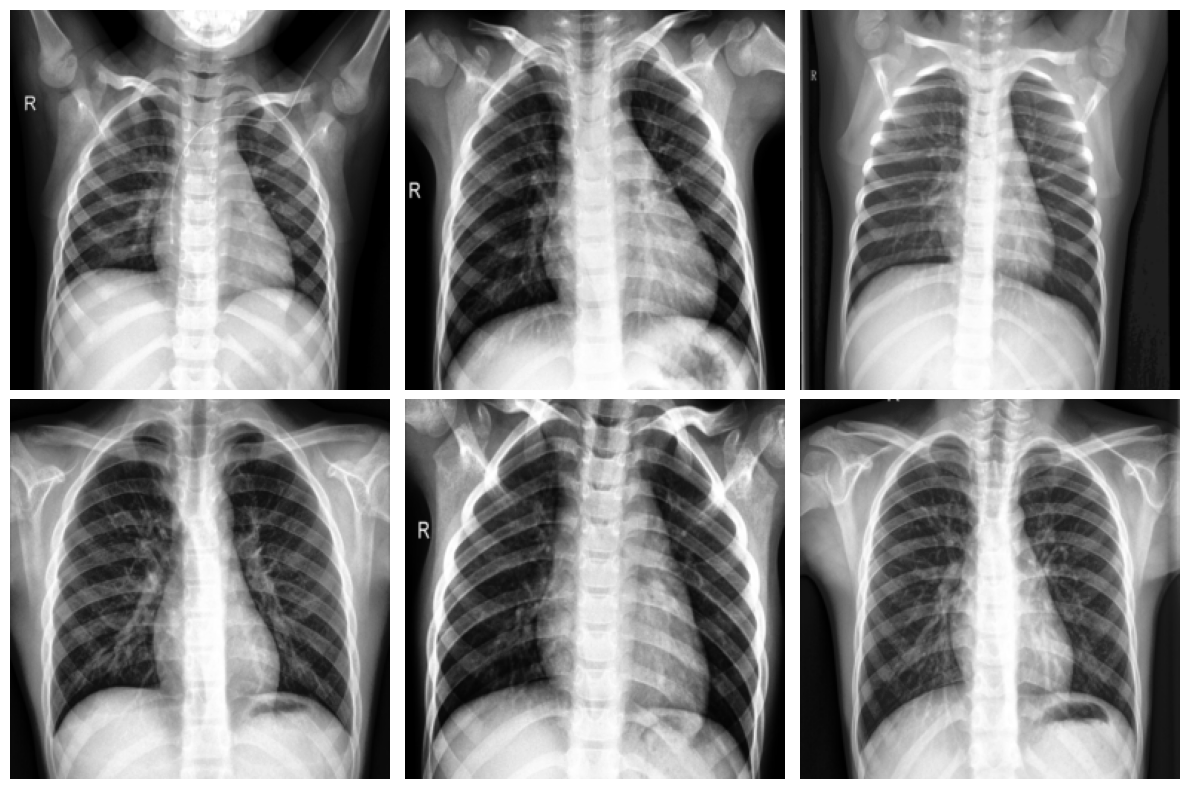

In [4]:
def show_dataset_images(dataloader, num_images=6, image_size=(256, 256)):
    # Retrieve a batch of images (and labels if they exist)
    data = next(iter(dataloader))
    if isinstance(data, tuple) and len(data) == 2:
        images, labels = data
    else:
        images = data
        labels = [None] * len(images)  # Create a placeholder for labels if they are not available
    
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility

    for i in range(min(num_images, len(images))):  # Ensure not to exceed the number of images in the batch
        ax = plt.subplot(2, 3, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))  # Convert tensor image to numpy and fix the channel order
        mean = 0.5  # Mean used in Normalize
        std = 0.5   # Std used in Normalize
        img = std * img + mean  # Unnormalize the image
        img = np.clip(img, 0, 1)  # Clip values to ensure they're between 0 and 1

        img = cv2.resize(img, image_size)  # Resize the image to the desired size

        plt.imshow(img, cmap='gray')  # Use gray color map for X-ray images
        if labels[i] is not None:
            ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()

# Example usage (make sure you have a DataLoader available as trainloaders[0] from your federated setup)
show_dataset_images(trainloaders[0], num_images=6, image_size=(256, 256))

In [5]:
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Input is 1 channel
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, 7),
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
def train(net, trainloader, epochs: int, optimizer):
    """Train the autoencoder on the training set."""
    criterion = torch.nn.MSELoss()
    net.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in trainloader:
            images = batch.to(DEVICE)  # Assuming the DataLoader returns a tuple (images, labels)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_loss = total_loss / len(trainloader)
        print(f"Epoch {epoch+1}: train loss {average_loss:.4f}")
        
def test(net, testloader):
    """Evaluate the autoencoder on the test set."""
    criterion = torch.nn.MSELoss()
    total_loss = 0.0
    net.to(DEVICE)  # Move model to GPU if available
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images = batch[0].to(DEVICE)  # Move data to GPU if available
            outputs = net(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    average_loss = total_loss / len(testloader)
    print(f"Test loss: {average_loss:.4f}")
    return average_loss

In [7]:
def get_parameters(net) -> List[np.ndarray]:
    # Return the parameters of the network as a list of NumPy arrays.
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    # Set the parameters of the network from a list of NumPy arrays.
    params_dict = zip(net.state_dict().keys(), parameters)  # Pair parameter names with given arrays.
    # Create an ordered dictionary of parameters, converting arrays to tensors.
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})  
    net.load_state_dict(state_dict, strict=True)  # Load the parameters into the network.

In [8]:
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Parameters,
    Scalar,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)

In [9]:
class FlowerClient(fl.client.Client):
    def __init__(self, cid, net, trainloader, optimizer, scheduler, epochs_per_round):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epochs_per_round = epochs_per_round  # Number of epochs per client per round

    def get_parameters(self, ins: fl.common.GetParametersIns) -> fl.common.GetParametersRes:
        print(f"[Client {self.cid}] get_parameters")
        ndarrays = get_parameters(self.net)
        parameters = ndarrays_to_parameters(ndarrays)
        status = fl.common.Status(code=fl.common.Code.OK, message="Parameters retrieved")
        return fl.common.GetParametersRes(status=status, parameters=parameters)

    def fit(self, ins: fl.common.FitIns) -> fl.common.FitRes:
        print(f"[Client {self.cid}] fit, config: {ins.config}")
        ndarrays = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays)
        train(self.net, self.trainloader, epochs=self.epochs_per_round, optimizer=self.optimizer)
        updated_ndarrays = get_parameters(self.net)
        updated_parameters = ndarrays_to_parameters(updated_ndarrays)
        status = fl.common.Status(code=fl.common.Code.OK, message="Model trained")
        return fl.common.FitRes(status=status, parameters=updated_parameters, num_examples=len(self.trainloader), metrics={})

    def evaluate(self, ins: fl.common.EvaluateIns) -> fl.common.EvaluateRes:
        print(f"[Client {self.cid}] evaluate, config: {ins.config}")
        ndarrays = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays)

        # Perform reconstruction and calculate SSIM using trainloader
        total_ssim = 0.0
        total_items = 0
        self.net.eval()
        with torch.no_grad():
            for images in self.trainloader:
                images = images.to(DEVICE)  # Ensure that images are moved to the correct device
                outputs = self.net(images)
                
                # Convert images and outputs to numpy arrays for SSIM calculation
                images_np = images.cpu().numpy().transpose(0, 2, 3, 1)
                outputs_np = outputs.cpu().numpy().transpose(0, 2, 3, 1)
                
                for img, out in zip(images_np, outputs_np):
                    img_gray = TF.to_pil_image(img).convert("L")
                    out_gray = TF.to_pil_image(out).convert("L")
                    img_gray = np.array(img_gray)
                    out_gray = np.array(out_gray)
                    ssim_value = ssim(img_gray, out_gray, data_range=img_gray.max() - img_gray.min())
                    total_ssim += ssim_value
                total_items += images.size(0)

        average_ssim = total_ssim / total_items if total_items > 0 else 0

        return fl.common.EvaluateRes(
            status=fl.common.Status(code=fl.common.Code.OK, message="Evaluation completed"),
            loss=1 - average_ssim,  # Loss is 1 - SSIM to keep lower loss better
            num_examples=total_items,
            metrics={"ssim": average_ssim}  # Report SSIM
        )

In [10]:
def client_fn(cid) -> FlowerClient:
    net = SparseAutoencoder().to(DEVICE)  # Assuming SparseAutoencoder is the model class
    trainloader = trainloaders[int(cid)]
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)  # Set your desired learning rate here
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    return FlowerClient(cid, net, trainloader, optimizer, scheduler, epochs_per_round=3)  # Adjust number of epochs per client per round

In [11]:
import flwr as fl
from typing import Callable, Dict, List, Optional, Tuple, Union
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

import random
from flwr.server.strategy import Strategy
from flwr.common import Parameters, Scalar
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.client_proxy import FitIns, FitRes
from typing import List, Optional, Tuple, Union
import numpy as np
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional, Union
import flwr as fl
from flwr.server.strategy import Strategy
from flwr.server.client_manager import ClientManager
from flwr.common import Parameters, Scalar, FitIns, FitRes, EvaluateIns, EvaluateRes, parameters_to_ndarrays, ndarrays_to_parameters
from datetime import datetime
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [12]:
class FedCustom(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        initial_lr: float = 0.0005,  # Slightly smaller initial learning rate
        step_size: int = 30,  # Increase the step size to allow more rounds before decay
        gamma: float = 0.9,  # Adjust gamma to control the decay rate
    ) -> None:
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.redistributed_parameters = {}
        self.initial_lr = initial_lr
        self.step_size = step_size
        self.gamma = gamma
        self.scheduler = None  # Scheduler will be initialized later

    def initialize_parameters(self, client_manager: ClientManager) -> Optional[Parameters]:
        """Initialize global model parameters using Autoencoder."""
        net = SparseAutoencoder()  # Ensure the Autoencoder class is defined
        ndarrays = get_parameters(net)  # Ensure get_parameters function is defined
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[fl.server.client_proxy.ClientProxy, FitIns]]:
        """Configure the next round of training with redistributed models."""
        num_clients = len(client_manager)
        if num_clients < self.min_fit_clients:
            return []

        sample_size = int(num_clients * self.fraction_fit)
        sample_size = max(sample_size, self.min_fit_clients)
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=self.min_fit_clients)

        fit_configurations = [
            (client, FitIns(parameters, {"server_round": server_round}))
            for client in clients
        ]
        return fit_configurations

    def aggregate_parameters(self, parameters_list: List[List[np.ndarray]]) -> List[np.ndarray]:
        """Aggregate model parameters by averaging them."""
        num_models = len(parameters_list)
        aggregated_parameters = []
        for param_tuple in zip(*parameters_list):
            aggregated_param = np.mean(param_tuple, axis=0)
            aggregated_parameters.append(aggregated_param)
        return aggregated_parameters

    def aggregate_fit(
        self, server_round: int, results: List[Tuple[fl.server.client_proxy.ClientProxy, FitRes]], failures: List[Union[Tuple[fl.server.client_proxy.ClientProxy, FitRes], BaseException]]
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate client model updates and prepare the global model for redistribution."""
        if not results:
            return None, {}

        # Collect parameters from the results
        parameters_list = [parameters_to_ndarrays(res.parameters) for client, res in results]
        aggregated_parameters = self.aggregate_parameters(parameters_list)
        aggregated_parameters_fl = ndarrays_to_parameters(aggregated_parameters)

        # Save the latest model's state_dict
        net = SparseAutoencoder()  # Ensure the Autoencoder class is defined
        state_dict = aggregated_parameters_to_state_dict(aggregated_parameters)  # Convert aggregated_parameters to state_dict
        net.load_state_dict(state_dict)
        torch.save(net.state_dict(), "latest_model.pth")

        return aggregated_parameters_fl, {}

    def configure_evaluate(self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[fl.server.client_proxy.ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation or reconstruction."""
        if self.fraction_evaluate == 0.0:
            return []

        config = {"server_round": server_round, "task": "evaluate"}

        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        evaluate_ins = EvaluateIns(parameters, config=config)

        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(self, server_round: int, results: List[Tuple[fl.server.client_proxy.ClientProxy, EvaluateRes]], failures: List[Union[Tuple[fl.server.client_proxy.ClientProxy, EvaluateRes], BaseException]]) -> Tuple[Optional[float], Dict[str, Scalar]]:
        if not results:
            return None, {}

        total_ssim = 0.0
        total_examples = 0
        current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        ssim_file_path = 'ssim_scores.ncol'  # File to store SSIM scores
        evaluation_file_path = 'aggregated_evaluation_loss.txt'  # File to store evaluation losses

        ssim_scores = []  # List to store SSIM scores

        # Collect SSIM scores and compute the total SSIM
        for client, res in results:
            if 'ssim' in res.metrics:
                ssim_scores.append((client.cid, res.metrics['ssim']))

            total_ssim += res.metrics['ssim'] * res.num_examples
            total_examples += res.num_examples

        aggregated_ssim = total_ssim / total_examples if total_examples > 0 else None

        # Sort SSIM scores by client ID
        ssim_scores.sort(key=lambda x: int(x[0]))

        # Append new data to the SSIM file
        with open(ssim_file_path, 'a') as file:
            file.write(f"Time: {current_time} - Round {server_round}\n")
            for cid, ssim_value in ssim_scores:
                file.write(f"{cid} {ssim_value}\n")

        # Initialize and update the learning rate scheduler
        if self.scheduler is None:
            self.optimizer = torch.optim.Adam([torch.nn.Parameter(torch.tensor([1.0]))], lr=self.initial_lr)
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=self.step_size, gamma=self.gamma)

        # Update the scheduler every round
        if aggregated_ssim is not None:
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']

            # Append new data to the evaluation file
            with open(evaluation_file_path, 'a') as file:
                file.write(f"Time: {current_time} - Round {server_round} - LR {current_lr}\n")
                if aggregated_ssim is not None:
                    file.write(f"Aggregated Test SSIM: {aggregated_ssim:.4f}\n")
                    print(f"Saved aggregated SSIM value for round {server_round} in aggregated_evaluation_loss.txt")

        return aggregated_ssim, {}

    def evaluate(
        self, server_round: int, parameters: fl.common.Parameters
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
        """Evaluate global model parameters using an evaluation function."""
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients


def aggregated_parameters_to_state_dict(aggregated_parameters):
    """Convert aggregated parameters to a state dictionary."""
    state_dict = {}
    param_keys = list(SparseAutoencoder().state_dict().keys())
    for key, param in zip(param_keys, aggregated_parameters):
        state_dict[key] = torch.tensor(param)
    return state_dict

In [13]:
def clear_file(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'w') as file:
            file.truncate(0)  # Clear the file contents

# Define file paths
evaluation_loss_file = 'aggregated_evaluation_loss.txt'
reconstruction_error_file = 'ssim_scores.ncol'

# Clear the files if they exist
clear_file(evaluation_loss_file)
clear_file(reconstruction_error_file)

In [14]:
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=1000),
    strategy=FedCustom(),
    client_resources={"num_cpus": 1, "num_gpus": 0.05} ,
)

INFO :      Starting Flower simulation, config: num_rounds=1000, no round_timeout
2024-05-30 17:10:17,663	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'memory': 11993562318.0, 'object_store_memory': 5996781158.0, 'node:127.0.0.1': 1.0, 'CPU': 16.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.05}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 16 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=59936) D:\Anaconda\envs\Flower\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbo

(ClientAppActor pid=59936) [Client 1] fit, config: {'server_round': 1}
(ClientAppActor pid=56520) Epoch 1: train loss 0.6964


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=46096) [Client 1] evaluate, config: {'server_round': 1, 'task': 'evaluate'}


D:\Anaconda\envs\Flower\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 1 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 2 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 3 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 4 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) [Client 8] fit, config: {'server_round': 5} [repeated 49x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 5 in aggregated_evaluation_loss.txt
(ClientAppActor pid=60184) Epoch 3: train loss 0.2400 [repeated 149x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51948) [Client 3] evaluate, config: {'server_round': 6, 'task': 'evaluate'} [repeated 58x across cluster]
Saved aggregated SSIM value for round 6 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 7 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 8 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 9 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 1] fit, config: {'server_round': 10} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 10 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2369 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 11 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56520) [Client 5] evaluate, config: {'server_round': 11, 'task': 'evaluate'} [repeated 51x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 12 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 13 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 14 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 6] fit, config: {'server_round': 15} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 15 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) Epoch 3: train loss 0.2196 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 16 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 4] evaluate, config: {'server_round': 16, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 17 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 18 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 19 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 5] fit, config: {'server_round': 20} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 20 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2167 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 21 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 3] evaluate, config: {'server_round': 21, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 22 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 23 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 24 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=46096) [Client 4] fit, config: {'server_round': 25} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 25 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50724) Epoch 3: train loss 0.2198 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 26 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 1] evaluate, config: {'server_round': 26, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 27 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 28 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 29 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 6] fit, config: {'server_round': 30} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 30 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2400 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 31 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 0] evaluate, config: {'server_round': 31, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 32 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 33 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 34 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=56416) [Client 7] fit, config: {'server_round': 35} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 35 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.1934 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 36 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 9] evaluate, config: {'server_round': 36, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 37 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 38 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 39 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=60184) [Client 6] fit, config: {'server_round': 40} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 40 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) Epoch 3: train loss 0.2110 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 41 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 7] evaluate, config: {'server_round': 41, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 42 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 43 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 44 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 9] fit, config: {'server_round': 45} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 45 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2057 [repeated 151x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 46 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56520) [Client 4] evaluate, config: {'server_round': 46, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 47 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 48 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 49 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50724) [Client 4] fit, config: {'server_round': 50} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 50 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 2: train loss 0.2374 [repeated 154x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 51 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 8] evaluate, config: {'server_round': 51, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 52 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 53 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 54 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 9] fit, config: {'server_round': 55} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 55 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2030 [repeated 145x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 56 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) [Client 5] evaluate, config: {'server_round': 56, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 57 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 58 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 59 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 4] fit, config: {'server_round': 60} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 60 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) Epoch 1: train loss 0.2079 [repeated 151x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 61 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 1] evaluate, config: {'server_round': 61, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 62 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 63 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 64 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=59936) [Client 7] fit, config: {'server_round': 65} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 65 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 2: train loss 0.2190 [repeated 152x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 66 in aggregated_evaluation_loss.txt
(ClientAppActor pid=54736) [Client 0] evaluate, config: {'server_round': 66, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 67 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 68 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 69 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) [Client 8] fit, config: {'server_round': 70} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 70 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) Epoch 2: train loss 0.1944 [repeated 157x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 71 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 1] evaluate, config: {'server_round': 71, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 72 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 73 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 74 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51948) [Client 0] fit, config: {'server_round': 75} [repeated 50x across cluster]
Saved aggregated SSIM value for round 75 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 2: train loss 0.1960 [repeated 153x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 76 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 1] evaluate, config: {'server_round': 76, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 77 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 78 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 79 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50724) [Client 8] fit, config: {'server_round': 80} [repeated 50x across cluster]
Saved aggregated SSIM value for round 80 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 2: train loss 0.2160 [repeated 152x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 81 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=60184) [Client 2] evaluate, config: {'server_round': 81, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 82 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 83 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 84 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 86]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 0] fit, config: {'server_round': 85} [repeated 50x across cluster]
Saved aggregated SSIM value for round 85 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 2: train loss 0.2097 [repeated 151x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 86 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54736) [Client 5] evaluate, config: {'server_round': 86, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 87 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 88 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 89 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=50724) [Client 4] fit, config: {'server_round': 90} [repeated 50x across cluster]


INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 90 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=59936) Epoch 3: train loss 0.2140 [repeated 152x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 91 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=56416) [Client 6] evaluate, config: {'server_round': 91, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 92 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 93 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 94 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 95 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 7] fit, config: {'server_round': 96} [repeated 51x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 2: train loss 0.2125 [repeated 149x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 96 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 5] evaluate, config: {'server_round': 96, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 97 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 98 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 99 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 101]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 100 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 3] fit, config: {'server_round': 101} [repeated 55x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54736) Epoch 3: train loss 0.2032 [repeated 154x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 102]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 101 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51948) [Client 1] evaluate, config: {'server_round': 101, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 103]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 102 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 104]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 103 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 105]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 104 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 106]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 105 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) [Client 8] fit, config: {'server_round': 106} [repeated 54x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 3: train loss 0.1893 [repeated 153x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 107]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 106 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54736) [Client 6] evaluate, config: {'server_round': 106, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 108]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 107 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 109]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 108 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 110]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 109 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 111]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 110 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 1] fit, config: {'server_round': 111} [repeated 46x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=59936) Epoch 2: train loss 0.1873 [repeated 137x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 112]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 111 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51948) [Client 3] evaluate, config: {'server_round': 111, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 113]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 112 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 114]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 113 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 115]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 114 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 116]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 115 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 7] fit, config: {'server_round': 116} [repeated 54x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.2112 [repeated 162x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 117]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 116 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54736) [Client 2] evaluate, config: {'server_round': 116, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 118]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 117 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 119]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 118 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 120]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 119 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 121]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 120 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 2] fit, config: {'server_round': 121} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=56416) Epoch 3: train loss 0.2032 [repeated 157x across cluster]


INFO :      
INFO :      [ROUND 122]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 121 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=57568) [Client 2] evaluate, config: {'server_round': 122, 'task': 'evaluate'} [repeated 58x across cluster]


INFO :      
INFO :      [ROUND 123]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 122 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 124]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 123 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 125]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 124 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 126]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 125 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56520) [Client 4] fit, config: {'server_round': 126} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=57712) Epoch 3: train loss 0.1811 [repeated 150x across cluster]


INFO :      
INFO :      [ROUND 127]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 126 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) [Client 4] evaluate, config: {'server_round': 127, 'task': 'evaluate'} [repeated 43x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 128]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 127 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 129]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 128 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 130]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 129 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 131]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 130 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) [Client 2] fit, config: {'server_round': 131} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 132]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) Epoch 3: train loss 0.1894 [repeated 150x across cluster]
Saved aggregated SSIM value for round 131 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 133]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) [Client 8] evaluate, config: {'server_round': 132, 'task': 'evaluate'} [repeated 54x across cluster]
Saved aggregated SSIM value for round 132 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 134]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 133 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 135]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 134 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 136]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 135 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=60184) [Client 0] fit, config: {'server_round': 136} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 137]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 136 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) Epoch 3: train loss 0.2049 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 138]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 137 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 4] evaluate, config: {'server_round': 137, 'task': 'evaluate'} [repeated 55x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 139]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 138 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 140]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 139 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 141]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 140 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 9] fit, config: {'server_round': 141} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 142]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 141 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.1997 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 143]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 142 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56520) [Client 4] evaluate, config: {'server_round': 142, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 144]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 143 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 145]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 144 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 146]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 145 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50724) [Client 0] fit, config: {'server_round': 146} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 147]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 146 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) Epoch 3: train loss 0.1827 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 148]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 147 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 6] evaluate, config: {'server_round': 147, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 149]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 148 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 150]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 149 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 151]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 150 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 6] fit, config: {'server_round': 151} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 152]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 151 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) Epoch 3: train loss 0.2041 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 153]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 152 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 6] evaluate, config: {'server_round': 152, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 154]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 153 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 155]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 154 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 156]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 155 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 4] fit, config: {'server_round': 156} [repeated 47x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 157]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 156 in aggregated_evaluation_loss.txt
(ClientAppActor pid=60184) Epoch 3: train loss 0.1983 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 158]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 7] evaluate, config: {'server_round': 157, 'task': 'evaluate'} [repeated 48x across cluster]
Saved aggregated SSIM value for round 157 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 159]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 158 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 160]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 159 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 161]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 160 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56520) [Client 1] fit, config: {'server_round': 161} [repeated 53x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 162]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 161 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2109 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 163]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) [Client 6] evaluate, config: {'server_round': 162, 'task': 'evaluate'} [repeated 47x across cluster]
Saved aggregated SSIM value for round 162 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 164]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 163 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 165]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 164 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 166]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 165 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 3] fit, config: {'server_round': 166} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.1883 [repeated 149x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 167]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 166 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 9] evaluate, config: {'server_round': 166, 'task': 'evaluate'} [repeated 45x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 168]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 167 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 169]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 168 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 170]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 169 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 171]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 170 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 3] fit, config: {'server_round': 171} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=56416) Epoch 3: train loss 0.2107 [repeated 151x across cluster]


INFO :      
INFO :      [ROUND 172]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 171 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 8] evaluate, config: {'server_round': 171, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 173]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 172 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 174]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 173 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 175]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 174 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 176]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 175 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50724) [Client 9] fit, config: {'server_round': 176} [repeated 55x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 177]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51948) Epoch 3: train loss 0.1785 [repeated 150x across cluster]
Saved aggregated SSIM value for round 176 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) [Client 4] evaluate, config: {'server_round': 177, 'task': 'evaluate'} [repeated 51x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 178]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 177 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 179]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 178 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 180]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 179 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 181]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 180 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56520) [Client 5] fit, config: {'server_round': 181} [repeated 54x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 182]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 181 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50724) Epoch 3: train loss 0.1977 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 183]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) [Client 6] evaluate, config: {'server_round': 182, 'task': 'evaluate'} [repeated 50x across cluster]
Saved aggregated SSIM value for round 182 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 184]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 183 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 185]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 184 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 186]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 185 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 2] fit, config: {'server_round': 186} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 187]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=60184) Epoch 3: train loss 0.1877 [repeated 150x across cluster]
Saved aggregated SSIM value for round 186 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 1] evaluate, config: {'server_round': 186, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 188]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 187 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 189]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 188 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 190]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 189 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 191]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 190 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 1] fit, config: {'server_round': 191} [repeated 55x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=60184) Epoch 3: train loss 0.1784 [repeated 150x across cluster]


INFO :      
INFO :      [ROUND 192]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 191 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 5] evaluate, config: {'server_round': 191, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 193]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 192 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 194]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 193 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 195]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 194 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 196]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 195 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 3] fit, config: {'server_round': 196} [repeated 45x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 197]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.1877 [repeated 150x across cluster]
Saved aggregated SSIM value for round 196 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 7] evaluate, config: {'server_round': 196, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 198]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 197 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 199]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 198 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 200]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 199 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51948) [Client 1] fit, config: {'server_round': 200} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 201]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 200 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 2: train loss 0.2035 [repeated 133x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 202]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 201 in aggregated_evaluation_loss.txt
(ClientAppActor pid=60184) [Client 8] evaluate, config: {'server_round': 201, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 203]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 202 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 204]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 203 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 205]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 204 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 0] fit, config: {'server_round': 205} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 206]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 205 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 2: train loss 0.2110 [repeated 152x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 207]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 206 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 0] evaluate, config: {'server_round': 206, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 208]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 207 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 209]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 208 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 210]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 209 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 7] fit, config: {'server_round': 210} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 211]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 210 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) Epoch 3: train loss 0.1998 [repeated 158x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 212]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 211 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) [Client 1] evaluate, config: {'server_round': 211, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 213]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 212 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 214]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 213 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 215]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 214 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 6] fit, config: {'server_round': 215} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 216]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 215 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 2: train loss 0.1819 [repeated 141x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 217]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54736) [Client 5] evaluate, config: {'server_round': 216, 'task': 'evaluate'} [repeated 49x across cluster]
Saved aggregated SSIM value for round 216 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 218]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 217 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 219]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 218 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 220]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 219 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=56416) [Client 8] fit, config: {'server_round': 220} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 221]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 220 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2029 [repeated 136x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) [Client 0] evaluate, config: {'server_round': 221, 'task': 'evaluate'} [repeated 42x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 222]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 221 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 223]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 222 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 224]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 223 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 225]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 224 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=57568) [Client 2] fit, config: {'server_round': 225} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 226]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 225 in aggregated_evaluation_loss.txt
(ClientAppActor pid=54736) Epoch 1: train loss 0.1985 [repeated 151x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 9] evaluate, config: {'server_round': 225, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 227]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 226 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 228]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 227 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 229]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 228 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 230]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 229 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=56416) [Client 2] fit, config: {'server_round': 230} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 231]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 230 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2033 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 0] evaluate, config: {'server_round': 230, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 232]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 231 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 233]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 232 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 234]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 233 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 235]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 234 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 2] fit, config: {'server_round': 235} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 236]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 235 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) Epoch 3: train loss 0.2095 [repeated 149x across cluster]
(ClientAppActor pid=46096) [Client 0] evaluate, config: {'server_round': 235, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 237]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 236 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 238]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 237 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 239]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 238 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 240]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 239 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 4] fit, config: {'server_round': 240} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 241]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 240 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56520) Epoch 3: train loss 0.1964 [repeated 150x across cluster]
(ClientAppActor pid=51948) [Client 3] evaluate, config: {'server_round': 240, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 242]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 241 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 243]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 242 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 244]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 243 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 245]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 244 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 5] fit, config: {'server_round': 245} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 246]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 245 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.1786 [repeated 150x across cluster]
(ClientAppActor pid=59936) [Client 8] evaluate, config: {'server_round': 245, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 247]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 246 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 248]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 247 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 249]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 248 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 250]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 249 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 0] fit, config: {'server_round': 250} [repeated 56x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 251]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 250 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) Epoch 3: train loss 0.1965 [repeated 150x across cluster]
(ClientAppActor pid=56416) [Client 3] evaluate, config: {'server_round': 250, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 252]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 251 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 253]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 252 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 254]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 253 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 255]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 254 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 6] fit, config: {'server_round': 255} [repeated 51x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 256]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 255 in aggregated_evaluation_loss.txt
(ClientAppActor pid=60184) Epoch 3: train loss 0.1778 [repeated 150x across cluster]
(ClientAppActor pid=56416) [Client 9] evaluate, config: {'server_round': 255, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 257]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 256 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 258]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 257 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 259]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 258 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 260]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 259 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 1] fit, config: {'server_round': 260} [repeated 47x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 261]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 260 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) Epoch 1: train loss 0.2282 [repeated 151x across cluster]
(ClientAppActor pid=56416) [Client 4] evaluate, config: {'server_round': 260, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 262]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 261 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 263]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 262 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 264]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 263 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 265]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 264 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 2] fit, config: {'server_round': 265} [repeated 54x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 266]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 265 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2075 [repeated 156x across cluster]
(ClientAppActor pid=60184) [Client 6] evaluate, config: {'server_round': 265, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 267]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 266 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 268]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 267 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 269]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 268 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 270]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 269 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 2] fit, config: {'server_round': 270} [repeated 48x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 271]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 270 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) Epoch 1: train loss 0.1970 [repeated 144x across cluster]
(ClientAppActor pid=51948) [Client 6] evaluate, config: {'server_round': 270, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 272]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 271 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 273]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 272 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 274]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 273 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 275]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 274 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 8] fit, config: {'server_round': 275} [repeated 51x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 276]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 275 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1861 [repeated 150x across cluster]
(ClientAppActor pid=56416) [Client 4] evaluate, config: {'server_round': 275, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 277]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 276 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 278]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 277 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 279]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 278 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 280]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 279 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 7] fit, config: {'server_round': 280} [repeated 52x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 281]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 280 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) Epoch 1: train loss 0.1998 [repeated 154x across cluster]
(ClientAppActor pid=50724) [Client 7] evaluate, config: {'server_round': 280, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 282]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 281 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 283]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 282 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 284]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 283 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 285]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 284 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 0] fit, config: {'server_round': 285} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 286]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 285 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1979 [repeated 146x across cluster]
(ClientAppActor pid=56416) [Client 8] evaluate, config: {'server_round': 285, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 287]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 286 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 288]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 287 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 289]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 288 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 290]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 289 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 7] fit, config: {'server_round': 290} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 291]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 290 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) Epoch 3: train loss 0.2096 [repeated 149x across cluster]
(ClientAppActor pid=56416) [Client 1] evaluate, config: {'server_round': 290, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 292]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 291 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 293]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 292 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 294]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 293 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 295]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 294 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 2] fit, config: {'server_round': 295} [repeated 58x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 296]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 295 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2026 [repeated 151x across cluster]
(ClientAppActor pid=57712) [Client 1] evaluate, config: {'server_round': 295, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 297]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 296 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 298]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 297 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 299]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 298 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 300]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 299 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 6] fit, config: {'server_round': 300} [repeated 51x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 301]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 300 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2074 [repeated 155x across cluster]
(ClientAppActor pid=56416) [Client 2] evaluate, config: {'server_round': 300, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 302]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 301 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 303]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 302 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 304]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 303 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 305]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 304 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 5] fit, config: {'server_round': 305} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 306]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 305 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2077 [repeated 150x across cluster]
(ClientAppActor pid=56520) [Client 9] evaluate, config: {'server_round': 305, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 307]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 306 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 308]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 307 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 309]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 308 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 310]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 309 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 5] fit, config: {'server_round': 310} [repeated 49x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 311]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 310 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) Epoch 3: train loss 0.2274 [repeated 144x across cluster]
(ClientAppActor pid=60184) [Client 0] evaluate, config: {'server_round': 310, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 312]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 311 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 313]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 312 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 314]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 313 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 315]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 314 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 3] fit, config: {'server_round': 315} [repeated 51x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 316]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 315 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 3: train loss 0.1962 [repeated 150x across cluster]
(ClientAppActor pid=56416) [Client 0] evaluate, config: {'server_round': 315, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 317]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 316 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 318]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 317 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 319]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 318 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 320]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 319 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 0] fit, config: {'server_round': 320} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 321]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 320 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56520) Epoch 3: train loss 0.1966 [repeated 150x across cluster]
(ClientAppActor pid=59936) [Client 2] evaluate, config: {'server_round': 320, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 322]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 321 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 323]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 322 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 324]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 323 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 325]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 324 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 3] fit, config: {'server_round': 325} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 326]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 325 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) Epoch 1: train loss 0.2272 [repeated 151x across cluster]
(ClientAppActor pid=56416) [Client 7] evaluate, config: {'server_round': 325, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 327]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 326 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 328]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 327 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 329]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 328 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 330]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 329 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=57712) [Client 3] fit, config: {'server_round': 330} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 331]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 330 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2024 [repeated 155x across cluster]
(ClientAppActor pid=56416) [Client 6] evaluate, config: {'server_round': 330, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 332]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 331 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 333]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 332 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 334]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 333 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 335]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 334 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 8] fit, config: {'server_round': 335} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 336]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 335 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2072 [repeated 149x across cluster]
(ClientAppActor pid=56416) [Client 8] evaluate, config: {'server_round': 335, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 337]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 336 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 338]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 337 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 339]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 338 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 340]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 339 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50724) [Client 7] fit, config: {'server_round': 340} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 341]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 340 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1968 [repeated 146x across cluster]
(ClientAppActor pid=57712) [Client 7] evaluate, config: {'server_round': 340, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 342]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 341 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 343]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 342 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 344]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 343 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 345]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 344 in aggregated_evaluation_loss.txt
(ClientAppActor pid=54736) [Client 0] fit, config: {'server_round': 345} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=59936) Epoch 3: train loss 0.2272 [repeated 138x across cluster]
(ClientAppActor pid=60184) [Client 4] evaluate, config: {'server_round': 344, 'task': 'evaluate'} [repeated 40x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 346]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 345 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 347]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 346 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 348]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 347 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 349]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 348 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 350]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 349 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 3] fit, config: {'server_round': 350} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.2270 [repeated 152x across cluster]
(ClientAppActor pid=57568) [Client 8] evaluate, config: {'server_round': 350, 'task': 'evaluate'} [repeated 51x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 351]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 350 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 352]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 351 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 353]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 352 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 354]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 353 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 355]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 9] fit, config: {'server_round': 354} [repeated 49x across cluster]
Saved aggregated SSIM value for round 354 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54736) Epoch 3: train loss 0.1967 [repeated 150x across cluster]
(ClientAppActor pid=57712) [Client 6] evaluate, config: {'server_round': 354, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 356]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 355 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 357]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 356 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 358]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 357 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 359]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 358 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 360]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 359 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 3] fit, config: {'server_round': 360} [repeated 51x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 3: train loss 0.1970 [repeated 151x across cluster]
(ClientAppActor pid=56416) [Client 7] evaluate, config: {'server_round': 359, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 361]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 360 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 362]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 361 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 363]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 362 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 364]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 363 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 365]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 364 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 9] fit, config: {'server_round': 365} [repeated 57x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 3: train loss 0.1989 [repeated 150x across cluster]
(ClientAppActor pid=54736) [Client 4] evaluate, config: {'server_round': 364, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 366]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 365 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 367]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 366 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 368]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 367 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 369]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 368 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 370]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 369 in aggregated_evaluation_loss.txt
(ClientAppActor pid=60184) [Client 8] fit, config: {'server_round': 370} [repeated 52x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=56416) Epoch 3: train loss 0.2068 [repeated 158x across cluster]
(ClientAppActor pid=57568) [Client 1] evaluate, config: {'server_round': 370, 'task': 'evaluate'} [repeated 51x across cluster]


INFO :      
INFO :      [ROUND 371]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 370 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 372]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 371 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 373]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 372 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 374]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 373 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 375]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 374 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 9] fit, config: {'server_round': 375} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) Epoch 3: train loss 0.1970 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 6] evaluate, config: {'server_round': 375, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 376]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 375 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 377]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 376 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 378]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 377 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 379]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 378 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 380]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 379 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50724) [Client 2] fit, config: {'server_round': 380} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 381]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51948) Epoch 3: train loss 0.1959 [repeated 150x across cluster]
(ClientAppActor pid=56520) [Client 7] evaluate, config: {'server_round': 380, 'task': 'evaluate'} [repeated 59x across cluster]
Saved aggregated SSIM value for round 380 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 382]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 381 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 383]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 382 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 384]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 383 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 385]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 384 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 9] fit, config: {'server_round': 385} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.2017 [repeated 150x across cluster]
(ClientAppActor pid=56520) [Client 3] evaluate, config: {'server_round': 385, 'task': 'evaluate'} [repeated 41x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 386]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 385 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 387]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 386 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 388]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 387 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 389]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 388 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 390]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 389 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 8] fit, config: {'server_round': 390} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) Epoch 3: train loss 0.1960 [repeated 148x across cluster]
(ClientAppActor pid=56520) [Client 6] evaluate, config: {'server_round': 390, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 391]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 390 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 392]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 391 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 393]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 392 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 394]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 393 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 395]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 394 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 0] fit, config: {'server_round': 395} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) Epoch 3: train loss 0.1960 [repeated 151x across cluster]
(ClientAppActor pid=56520) [Client 8] evaluate, config: {'server_round': 395, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 396]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 395 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 397]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 396 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 398]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 397 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 399]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 398 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 400]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 399 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56520) [Client 1] fit, config: {'server_round': 400} [repeated 53x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.2018 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 6] evaluate, config: {'server_round': 400, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 401]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 400 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 402]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 401 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 403]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 402 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 404]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 403 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 405]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 404 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 1] fit, config: {'server_round': 405} [repeated 48x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 406]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.1764 [repeated 151x across cluster]
(ClientAppActor pid=46096) [Client 8] evaluate, config: {'server_round': 405, 'task': 'evaluate'} [repeated 50x across cluster]
Saved aggregated SSIM value for round 405 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 407]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 406 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 408]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 407 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 409]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 408 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 410]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 409 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 7] fit, config: {'server_round': 410} [repeated 49x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.1770 [repeated 143x across cluster]
(ClientAppActor pid=50724) [Client 4] evaluate, config: {'server_round': 409, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 411]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 410 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 412]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 411 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 413]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 412 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 414]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 413 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 415]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 414 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 1] fit, config: {'server_round': 415} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 3: train loss 0.2269 [repeated 151x across cluster]
(ClientAppActor pid=56520) [Client 0] evaluate, config: {'server_round': 414, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 416]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 415 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 417]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 416 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 418]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 417 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 419]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 418 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 420]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 419 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 1] fit, config: {'server_round': 420} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.2072 [repeated 147x across cluster]
(ClientAppActor pid=56416) [Client 4] evaluate, config: {'server_round': 419, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 421]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 420 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 422]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 421 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 423]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 422 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 424]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 423 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 425]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 424 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 0] fit, config: {'server_round': 425} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.1965 [repeated 152x across cluster]
(ClientAppActor pid=56416) [Client 4] evaluate, config: {'server_round': 424, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 426]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 425 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 427]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 426 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 428]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 427 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 429]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 428 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 430]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 429 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 3] fit, config: {'server_round': 430} [repeated 57x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50724) Epoch 3: train loss 0.1958 [repeated 155x across cluster]
(ClientAppActor pid=46096) [Client 2] evaluate, config: {'server_round': 429, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 431]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 430 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 432]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 431 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 433]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 432 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 434]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 433 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 435]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 434 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 5] fit, config: {'server_round': 435} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.1954 [repeated 149x across cluster]
(ClientAppActor pid=46096) [Client 0] evaluate, config: {'server_round': 435, 'task': 'evaluate'} [repeated 51x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 436]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 435 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 437]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 436 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 438]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 437 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 439]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 438 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 440]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 439 in aggregated_evaluation_loss.txt
(ClientAppActor pid=54736) [Client 3] fit, config: {'server_round': 440} [repeated 52x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=60184) Epoch 3: train loss 0.2087 [repeated 153x across cluster]
(ClientAppActor pid=46096) [Client 5] evaluate, config: {'server_round': 440, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 441]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 440 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 442]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 441 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 443]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 442 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 444]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 443 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 445]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 444 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 7] fit, config: {'server_round': 445} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 446]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.1983 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 8] evaluate, config: {'server_round': 445, 'task': 'evaluate'} [repeated 55x across cluster]
Saved aggregated SSIM value for round 445 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 447]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 446 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 448]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 447 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 449]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 448 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 450]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 449 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 6] fit, config: {'server_round': 450} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 451]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50724) Epoch 3: train loss 0.1766 [repeated 150x across cluster]
(ClientAppActor pid=59936) [Client 4] evaluate, config: {'server_round': 450, 'task': 'evaluate'} [repeated 52x across cluster]
Saved aggregated SSIM value for round 450 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 452]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 451 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 453]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 452 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 454]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 453 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 455]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 454 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 6] fit, config: {'server_round': 455} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 456]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=60184) Epoch 3: train loss 0.1957 [repeated 150x across cluster]
(ClientAppActor pid=50724) [Client 4] evaluate, config: {'server_round': 455, 'task': 'evaluate'} [repeated 52x across cluster]
Saved aggregated SSIM value for round 455 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 457]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 456 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 458]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 457 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 459]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 458 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 460]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 459 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 6] fit, config: {'server_round': 460} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=56416) Epoch 3: train loss 0.2266 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 4] evaluate, config: {'server_round': 460, 'task': 'evaluate'} [repeated 41x across cluster]


INFO :      
INFO :      [ROUND 461]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 460 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 462]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 461 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 463]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 462 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 464]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 463 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 465]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 464 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 2] fit, config: {'server_round': 465} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.2014 [repeated 146x across cluster]
(ClientAppActor pid=56416) [Client 9] evaluate, config: {'server_round': 464, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 466]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 465 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 467]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 466 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 468]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 467 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 469]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 468 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 470]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 469 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 1] fit, config: {'server_round': 470} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) Epoch 3: train loss 0.2015 [repeated 149x across cluster]
(ClientAppActor pid=51948) [Client 9] evaluate, config: {'server_round': 469, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 471]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 470 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 472]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 471 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 473]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 472 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 474]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 473 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 475]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 474 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 4] fit, config: {'server_round': 475} [repeated 49x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.1858 [repeated 148x across cluster]
(ClientAppActor pid=57712) [Client 6] evaluate, config: {'server_round': 474, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 476]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 475 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 477]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 476 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 478]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 477 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 479]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 478 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 480]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 479 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 7] fit, config: {'server_round': 480} [repeated 51x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54736) Epoch 3: train loss 0.1955 [repeated 157x across cluster]
(ClientAppActor pid=54736) [Client 3] evaluate, config: {'server_round': 480, 'task': 'evaluate'} [repeated 51x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 481]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 480 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 482]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 481 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 483]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 482 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 484]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 483 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 485]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 484 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 5] fit, config: {'server_round': 485} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) Epoch 3: train loss 0.1857 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 2] evaluate, config: {'server_round': 485, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 486]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 485 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 487]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 486 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 488]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 487 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 489]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 488 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 490]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 489 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 3] fit, config: {'server_round': 490} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.2268 [repeated 140x across cluster]
(ClientAppActor pid=57568) [Client 7] evaluate, config: {'server_round': 489, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 491]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 490 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 492]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 491 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 493]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 492 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 494]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 493 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 495]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 494 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 6] fit, config: {'server_round': 495} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 2: train loss 0.2281 [repeated 146x across cluster]
(ClientAppActor pid=57712) [Client 3] evaluate, config: {'server_round': 494, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 496]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 495 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 497]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 496 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 498]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 497 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 499]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 498 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 500]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 499 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 6] fit, config: {'server_round': 500} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 3: train loss 0.1962 [repeated 149x across cluster]
(ClientAppActor pid=56416) [Client 7] evaluate, config: {'server_round': 499, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 501]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 500 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 502]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 501 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 503]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 502 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 504]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 503 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 505]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 504 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 2] fit, config: {'server_round': 505} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 2: train loss 0.2107 [repeated 150x across cluster]
(ClientAppActor pid=57712) [Client 9] evaluate, config: {'server_round': 504, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 506]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 505 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 507]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 506 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 508]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 507 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 509]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 508 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 510]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 509 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 5] fit, config: {'server_round': 510} [repeated 59x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=59936) Epoch 3: train loss 0.1953 [repeated 162x across cluster]
(ClientAppActor pid=50724) [Client 4] evaluate, config: {'server_round': 509, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 511]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 510 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 512]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 511 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 513]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 512 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 514]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 513 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 515]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 514 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) [Client 2] fit, config: {'server_round': 515} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) Epoch 3: train loss 0.1980 [repeated 149x across cluster]
(ClientAppActor pid=56416) [Client 6] evaluate, config: {'server_round': 514, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 516]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 515 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 517]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 516 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 518]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 517 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 519]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 518 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 520]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 519 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 4] fit, config: {'server_round': 520} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.1963 [repeated 145x across cluster]
(ClientAppActor pid=56416) [Client 6] evaluate, config: {'server_round': 519, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 521]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 520 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 522]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 521 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 523]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 522 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 524]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 523 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 525]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 524 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 4] fit, config: {'server_round': 525} [repeated 54x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) Epoch 3: train loss 0.2083 [repeated 156x across cluster]
(ClientAppActor pid=57712) [Client 8] evaluate, config: {'server_round': 524, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 526]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 525 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 527]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 526 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 528]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 527 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 529]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 528 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 530]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 529 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 7] fit, config: {'server_round': 530} [repeated 46x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.1762 [repeated 146x across cluster]
(ClientAppActor pid=56416) [Client 9] evaluate, config: {'server_round': 529, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 531]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 530 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 532]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 531 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 533]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 532 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 534]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 533 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 535]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 534 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 4] fit, config: {'server_round': 535} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=59936) Epoch 3: train loss 0.2067 [repeated 150x across cluster]
(ClientAppActor pid=56416) [Client 3] evaluate, config: {'server_round': 534, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 536]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 535 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 537]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 536 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 538]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 537 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 539]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 538 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 540]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 539 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 7] fit, config: {'server_round': 540} [repeated 51x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) Epoch 3: train loss 0.2082 [repeated 153x across cluster]
(ClientAppActor pid=46096) [Client 5] evaluate, config: {'server_round': 539, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 541]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 540 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 542]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 541 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 543]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 542 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 544]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 543 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 545]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 544 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 7] fit, config: {'server_round': 545} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.1954 [repeated 154x across cluster]
(ClientAppActor pid=56416) [Client 6] evaluate, config: {'server_round': 545, 'task': 'evaluate'} [repeated 54x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 546]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 545 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 547]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 546 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 548]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 547 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 549]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 548 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 550]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 549 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 2] fit, config: {'server_round': 550} [repeated 49x across cluster]
(ClientAppActor pid=46096) Epoch 3: train loss 0.2081 [repeated 136x across cluster]
(ClientAppActor pid=60184) [Client 7] evaluate, config: {'server_round': 549, 'task': 'evaluate'} [repeated 46x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 551]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 550 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 552]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 551 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 553]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 552 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 554]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 553 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 1] fit, config: {'server_round': 554} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 555]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 554 in aggregated_evaluation_loss.txt
(ClientAppActor pid=54736) Epoch 3: train loss 0.1982 [repeated 134x across cluster]
(ClientAppActor pid=57712) [Client 5] evaluate, config: {'server_round': 554, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 556]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 555 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 557]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 556 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 558]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 557 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 559]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 558 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 9] fit, config: {'server_round': 559} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 560]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 559 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.1951 [repeated 150x across cluster]
(ClientAppActor pid=59936) [Client 4] evaluate, config: {'server_round': 559, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 561]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 560 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 562]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 561 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 563]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 562 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 564]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 563 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 6] fit, config: {'server_round': 564} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 565]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) Epoch 3: train loss 0.1950 [repeated 150x across cluster]
(ClientAppActor pid=56520) [Client 3] evaluate, config: {'server_round': 564, 'task': 'evaluate'} [repeated 49x across cluster]
Saved aggregated SSIM value for round 564 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 566]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 565 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 567]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 566 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 568]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 567 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 569]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 568 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 5] fit, config: {'server_round': 569} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=56416) Epoch 3: train loss 0.1856 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 5] evaluate, config: {'server_round': 569, 'task': 'evaluate'} [repeated 42x across cluster]


INFO :      
INFO :      [ROUND 570]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 569 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 571]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 570 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 572]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 571 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 573]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 572 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 574]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 573 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 4] fit, config: {'server_round': 574} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 575]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 574 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.1961 [repeated 150x across cluster]
(ClientAppActor pid=50724) [Client 4] evaluate, config: {'server_round': 574, 'task': 'evaluate'} [repeated 59x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 576]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 575 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 577]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 576 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 578]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 577 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 579]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 578 in aggregated_evaluation_loss.txt
(ClientAppActor pid=54736) [Client 7] fit, config: {'server_round': 579} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 580]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 579 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2082 [repeated 150x across cluster]
(ClientAppActor pid=51948) [Client 5] evaluate, config: {'server_round': 579, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 581]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 580 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 582]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 581 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 583]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 582 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 584]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 583 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 9] fit, config: {'server_round': 584} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 585]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 584 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.1950 [repeated 150x across cluster]
(ClientAppActor pid=60184) [Client 5] evaluate, config: {'server_round': 584, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 586]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 585 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 587]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 586 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 588]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 587 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 589]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 588 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 8] fit, config: {'server_round': 589} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 590]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 589 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2012 [repeated 150x across cluster]
(ClientAppActor pid=56520) [Client 3] evaluate, config: {'server_round': 589, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 591]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 590 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 592]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 591 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 593]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 592 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 594]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 593 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 5] fit, config: {'server_round': 594} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 595]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 594 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2264 [repeated 150x across cluster]
(ClientAppActor pid=59936) [Client 7] evaluate, config: {'server_round': 594, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 596]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 595 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 597]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 596 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 598]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 597 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 599]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 598 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 3] fit, config: {'server_round': 599} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 600]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 599 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2011 [repeated 150x across cluster]
(ClientAppActor pid=57712) [Client 5] evaluate, config: {'server_round': 599, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 601]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 600 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 602]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 601 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 603]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 602 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 604]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 603 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) [Client 1] fit, config: {'server_round': 604} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 605]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 604 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) Epoch 3: train loss 0.2065 [repeated 150x across cluster]
(ClientAppActor pid=54736) [Client 0] evaluate, config: {'server_round': 604, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 606]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 605 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 607]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 606 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 608]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 607 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 609]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 608 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 1] fit, config: {'server_round': 609} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 610]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 609 in aggregated_evaluation_loss.txt
(ClientAppActor pid=54736) Epoch 3: train loss 0.1949 [repeated 150x across cluster]
(ClientAppActor pid=56416) [Client 7] evaluate, config: {'server_round': 609, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 611]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 610 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 612]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 611 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 613]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 612 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 614]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 613 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 8] fit, config: {'server_round': 614} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 615]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 614 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2011 [repeated 150x across cluster]
(ClientAppActor pid=56416) [Client 3] evaluate, config: {'server_round': 614, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 616]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 615 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 617]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 616 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 618]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 617 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 619]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 618 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 2] fit, config: {'server_round': 619} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 620]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 619 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.2082 [repeated 150x across cluster]
(ClientAppActor pid=57712) [Client 7] evaluate, config: {'server_round': 619, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 621]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 620 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 622]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 621 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 623]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 622 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 624]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 623 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 5] fit, config: {'server_round': 624} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 625]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 624 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.1852 [repeated 150x across cluster]
(ClientAppActor pid=57712) [Client 8] evaluate, config: {'server_round': 624, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 626]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 625 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 627]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 626 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 628]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 627 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 629]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 628 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) [Client 8] fit, config: {'server_round': 629} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 630]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 629 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1757 [repeated 154x across cluster]
(ClientAppActor pid=57712) [Client 8] evaluate, config: {'server_round': 629, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 631]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 630 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 632]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 631 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 633]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 632 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 634]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 633 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=60184) [Client 5] fit, config: {'server_round': 634} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 635]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 634 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1955 [repeated 147x across cluster]
(ClientAppActor pid=60184) [Client 0] evaluate, config: {'server_round': 634, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 636]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 635 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 637]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 636 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 638]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 637 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 639]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 638 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 7] fit, config: {'server_round': 639} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 640]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 639 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1977 [repeated 150x across cluster]
(ClientAppActor pid=56416) [Client 2] evaluate, config: {'server_round': 639, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 641]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 640 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 642]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 641 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 643]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 642 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 644]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 643 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 8] fit, config: {'server_round': 644} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 645]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 644 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 2: train loss 0.2089 [repeated 159x across cluster]
(ClientAppActor pid=59936) [Client 3] evaluate, config: {'server_round': 644, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 646]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 645 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 647]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 646 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54736) 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 648]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 647 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 649]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 648 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 3] fit, config: {'server_round': 649} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 650]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 649 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 2: train loss 0.1861 [repeated 155x across cluster]
(ClientAppActor pid=60184) [Client 9] evaluate, config: {'server_round': 649, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 651]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 650 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 652]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 651 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 653]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 652 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 654]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 653 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 8] fit, config: {'server_round': 654} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 655]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 654 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) Epoch 3: train loss 0.1954 [repeated 151x across cluster]
(ClientAppActor pid=50724) [Client 4] evaluate, config: {'server_round': 654, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 656]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 655 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 657]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 656 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 658]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 657 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 659]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 658 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 8] fit, config: {'server_round': 659} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 660]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 659 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 2: train loss 0.1964 [repeated 150x across cluster]
(ClientAppActor pid=51948) [Client 4] evaluate, config: {'server_round': 659, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 661]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 660 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 662]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 661 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 663]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 662 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 664]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 663 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 4] fit, config: {'server_round': 664} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 665]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 664 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 3: train loss 0.2064 [repeated 152x across cluster]
(ClientAppActor pid=60184) [Client 2] evaluate, config: {'server_round': 664, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 666]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 665 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 667]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 666 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 668]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 667 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 669]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 668 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 0] fit, config: {'server_round': 669} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 670]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 669 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.2081 [repeated 157x across cluster]
(ClientAppActor pid=59936) [Client 0] evaluate, config: {'server_round': 669, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 671]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 670 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 672]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 671 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 673]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 672 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 674]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 673 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 8] fit, config: {'server_round': 674} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 675]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 674 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) Epoch 3: train loss 0.1980 [repeated 154x across cluster]
(ClientAppActor pid=46096) [Client 9] evaluate, config: {'server_round': 675, 'task': 'evaluate'} [repeated 51x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 676]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 675 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 677]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 676 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 678]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 677 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 679]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 678 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 680]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 8] fit, config: {'server_round': 679} [repeated 50x across cluster]
Saved aggregated SSIM value for round 679 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 681]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.1756 [repeated 151x across cluster]
(ClientAppActor pid=57568) [Client 9] evaluate, config: {'server_round': 680, 'task': 'evaluate'} [repeated 58x across cluster]
Saved aggregated SSIM value for round 680 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 682]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 681 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 683]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 682 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 684]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 683 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51948) [Client 2] fit, config: {'server_round': 684} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 685]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 684 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=57712) Epoch 3: train loss 0.2063 [repeated 150x across cluster]
(ClientAppActor pid=57568) [Client 7] evaluate, config: {'server_round': 685, 'task': 'evaluate'} [repeated 42x across cluster]


INFO :      
INFO :      [ROUND 686]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 685 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 687]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 686 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 688]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 687 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 689]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 688 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50724) [Client 3] fit, config: {'server_round': 689} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 690]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 689 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.2007 [repeated 149x across cluster]
(ClientAppActor pid=46096) [Client 9] evaluate, config: {'server_round': 690, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 691]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 690 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 692]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 691 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 693]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 692 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 694]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 693 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51948) [Client 3] fit, config: {'server_round': 694} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 695]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 694 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.1757 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 5] evaluate, config: {'server_round': 695, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 696]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 695 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 697]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 696 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 698]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 697 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 699]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 698 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=56416) [Client 3] fit, config: {'server_round': 699} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 700]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 699 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) Epoch 1: train loss 0.2060 [repeated 127x across cluster]
(ClientAppActor pid=56416) [Client 4] evaluate, config: {'server_round': 699, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 701]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 700 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 702]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 701 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 703]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 702 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 704]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 703 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) [Client 3] fit, config: {'server_round': 704} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 705]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 704 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2009 [repeated 145x across cluster]
(ClientAppActor pid=60184) [Client 9] evaluate, config: {'server_round': 704, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 706]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 705 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 707]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 706 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 708]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 707 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 709]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 708 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 5] fit, config: {'server_round': 709} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 710]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 709 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1754 [repeated 152x across cluster]
(ClientAppActor pid=56416) [Client 3] evaluate, config: {'server_round': 709, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 711]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 710 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 712]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 711 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 713]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 712 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 714]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 713 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 6] fit, config: {'server_round': 714} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 715]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 714 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) Epoch 1: train loss 0.1981 [repeated 154x across cluster]
(ClientAppActor pid=56416) [Client 8] evaluate, config: {'server_round': 714, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 716]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 715 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 717]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 716 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 718]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 717 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 719]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 718 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 5] fit, config: {'server_round': 719} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 720]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 719 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 2: train loss 0.2071 [repeated 155x across cluster]
(ClientAppActor pid=57712) [Client 6] evaluate, config: {'server_round': 719, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 721]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 720 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 722]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 721 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 723]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 722 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 724]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 723 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 4] fit, config: {'server_round': 724} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 725]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 724 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) Epoch 1: train loss 0.1946 [repeated 141x across cluster]
(ClientAppActor pid=56416) [Client 4] evaluate, config: {'server_round': 724, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 726]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 725 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 727]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 726 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 728]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 727 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 729]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 728 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 9] fit, config: {'server_round': 729} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 730]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 729 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2258 [repeated 151x across cluster]
(ClientAppActor pid=51948) [Client 6] evaluate, config: {'server_round': 729, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 731]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 730 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 732]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 731 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 733]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 732 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 734]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 733 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 4] fit, config: {'server_round': 734} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 735]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 734 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) Epoch 1: train loss 0.1956 [repeated 152x across cluster]
(ClientAppActor pid=56416) [Client 1] evaluate, config: {'server_round': 734, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 736]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 735 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 737]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 736 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 738]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 737 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 739]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 738 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 5] fit, config: {'server_round': 739} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 740]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 739 in aggregated_evaluation_loss.txt
(ClientAppActor pid=54736) Epoch 2: train loss 0.1977 [repeated 155x across cluster]
(ClientAppActor pid=60184) [Client 4] evaluate, config: {'server_round': 739, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 741]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 740 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 742]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 741 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 743]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 742 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 744]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 743 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 3] fit, config: {'server_round': 744} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 745]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 744 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1959 [repeated 143x across cluster]
(ClientAppActor pid=51948) [Client 2] evaluate, config: {'server_round': 744, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 746]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 745 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 747]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 746 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 748]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 747 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 749]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 748 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 2] fit, config: {'server_round': 749} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 750]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 749 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1757 [repeated 147x across cluster]
(ClientAppActor pid=56416) [Client 0] evaluate, config: {'server_round': 749, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 751]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 750 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 752]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 751 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 753]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 752 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 754]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 753 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 7] fit, config: {'server_round': 754} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 755]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 754 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1755 [repeated 154x across cluster]
(ClientAppActor pid=50724) [Client 5] evaluate, config: {'server_round': 754, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 756]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 755 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 757]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 756 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 758]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 757 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 759]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 758 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) [Client 4] fit, config: {'server_round': 759} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 760]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 759 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.1948 [repeated 145x across cluster]
(ClientAppActor pid=57712) [Client 5] evaluate, config: {'server_round': 759, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 761]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 760 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 762]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 761 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 763]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 762 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 764]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 763 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 6] fit, config: {'server_round': 764} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 765]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 764 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2077 [repeated 152x across cluster]
(ClientAppActor pid=54736) [Client 5] evaluate, config: {'server_round': 764, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 766]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 765 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 767]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 766 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 768]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 767 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 769]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 768 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 3] fit, config: {'server_round': 769} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 770]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 769 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2081 [repeated 150x across cluster]
(ClientAppActor pid=54736) [Client 9] evaluate, config: {'server_round': 769, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 771]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 770 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 772]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 771 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 773]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 772 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 774]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 773 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 8] fit, config: {'server_round': 774} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 775]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 774 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) Epoch 1: train loss 0.1955 [repeated 152x across cluster]
(ClientAppActor pid=46096) [Client 9] evaluate, config: {'server_round': 774, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 776]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 775 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 777]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 776 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 778]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 777 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 779]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 778 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50724) [Client 5] fit, config: {'server_round': 779} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 780]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 779 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1753 [repeated 148x across cluster]
(ClientAppActor pid=56416) [Client 1] evaluate, config: {'server_round': 779, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 781]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 780 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 782]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 781 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 783]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 782 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 784]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 783 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 9] fit, config: {'server_round': 784} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 785]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 784 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 2: train loss 0.1982 [repeated 164x across cluster]
(ClientAppActor pid=60184) [Client 0] evaluate, config: {'server_round': 784, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 786]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 785 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 787]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 786 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 788]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 787 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 789]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 788 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 5] fit, config: {'server_round': 789} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 790]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 789 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=59936) Epoch 3: train loss 0.2006 [repeated 155x across cluster]
(ClientAppActor pid=51948) [Client 8] evaluate, config: {'server_round': 789, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 791]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 790 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 792]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 791 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 793]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 792 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 794]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 793 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 9] fit, config: {'server_round': 794} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 795]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 794 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 3: train loss 0.2080 [repeated 150x across cluster]
(ClientAppActor pid=56416) [Client 0] evaluate, config: {'server_round': 794, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 796]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 795 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 797]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 796 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 798]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 797 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 799]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 798 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50724) [Client 9] fit, config: {'server_round': 799} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 800]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 799 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.1850 [repeated 148x across cluster]
(ClientAppActor pid=56416) [Client 5] evaluate, config: {'server_round': 799, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 801]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 800 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 802]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 801 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 803]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 802 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 804]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 803 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) [Client 1] fit, config: {'server_round': 804} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 805]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 804 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 3: train loss 0.2078 [repeated 151x across cluster]
(ClientAppActor pid=54736) [Client 3] evaluate, config: {'server_round': 804, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 806]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 805 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 807]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 806 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 808]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 807 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 809]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 808 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54736) [Client 9] fit, config: {'server_round': 809} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 810]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 809 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=59936) Epoch 3: train loss 0.1947 [repeated 157x across cluster]
(ClientAppActor pid=59936) [Client 0] evaluate, config: {'server_round': 810, 'task': 'evaluate'} [repeated 51x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 811]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 810 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 812]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 811 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 813]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 812 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 814]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 813 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 7] fit, config: {'server_round': 814} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 815]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 814 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 816]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) Epoch 3: train loss 0.1948 [repeated 153x across cluster]
(ClientAppActor pid=57568) [Client 6] evaluate, config: {'server_round': 815, 'task': 'evaluate'} [repeated 55x across cluster]
Saved aggregated SSIM value for round 815 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 817]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 816 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 818]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 817 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 819]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 818 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 4] fit, config: {'server_round': 819} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 820]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 819 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 821]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.2080 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 5] evaluate, config: {'server_round': 820, 'task': 'evaluate'} [repeated 46x across cluster]
Saved aggregated SSIM value for round 820 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 822]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 821 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 823]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 822 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 824]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 823 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) [Client 1] fit, config: {'server_round': 824} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 825]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 824 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.2061 [repeated 149x across cluster]
(ClientAppActor pid=54736) [Client 7] evaluate, config: {'server_round': 825, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 826]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 825 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 827]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 826 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 828]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 827 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 829]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 828 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54736) [Client 4] fit, config: {'server_round': 829} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 830]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 829 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50724) Epoch 3: train loss 0.2007 [repeated 150x across cluster]
(ClientAppActor pid=57712) [Client 5] evaluate, config: {'server_round': 829, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 831]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 830 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 832]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 831 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 833]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 832 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 834]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 833 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 7] fit, config: {'server_round': 834} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 835]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 834 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.2260 [repeated 144x across cluster]
(ClientAppActor pid=57712) [Client 1] evaluate, config: {'server_round': 834, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 836]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 835 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 837]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 836 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 838]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 837 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 839]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 838 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 6] fit, config: {'server_round': 839} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 840]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 839 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 3: train loss 0.2078 [repeated 155x across cluster]
(ClientAppActor pid=57568) [Client 6] evaluate, config: {'server_round': 840, 'task': 'evaluate'} [repeated 51x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 841]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 840 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 842]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 841 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 843]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 842 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 844]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 843 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 8] fit, config: {'server_round': 844} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 845]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 844 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=57568) Epoch 2: train loss 0.2077 [repeated 136x across cluster]
(ClientAppActor pid=56416) [Client 8] evaluate, config: {'server_round': 844, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 846]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 845 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 847]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 846 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 848]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 847 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 849]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 848 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 6] fit, config: {'server_round': 849} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 850]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 849 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 2: train loss 0.2269 [repeated 140x across cluster]
(ClientAppActor pid=59936) [Client 4] evaluate, config: {'server_round': 849, 'task': 'evaluate'} [repeated 50x across cluster]
(ClientAppActor pid=51948) 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 851]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 850 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 852]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 851 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 853]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 852 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 854]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 853 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 2] fit, config: {'server_round': 854} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 855]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 854 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 2: train loss 0.1969 [repeated 151x across cluster]
(ClientAppActor pid=60184) [Client 1] evaluate, config: {'server_round': 854, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 856]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 855 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 857]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 856 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 858]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 857 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 859]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 858 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 9] fit, config: {'server_round': 859} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 860]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 859 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=46096) Epoch 2: train loss 0.1859 [repeated 158x across cluster]
(ClientAppActor pid=54736) [Client 9] evaluate, config: {'server_round': 859, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 861]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 860 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 862]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 861 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 863]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 862 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 864]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 863 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 6] fit, config: {'server_round': 864} [repeated 52x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 865]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 864 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.2007 [repeated 139x across cluster]
(ClientAppActor pid=56416) [Client 3] evaluate, config: {'server_round': 864, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 866]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 865 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 867]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 866 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 868]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 867 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 869]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 868 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 5] fit, config: {'server_round': 869} [repeated 48x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 870]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 869 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1975 [repeated 154x across cluster]
(ClientAppActor pid=60184) [Client 7] evaluate, config: {'server_round': 869, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 871]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 870 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 872]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 871 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 873]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 872 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 874]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 873 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 5] fit, config: {'server_round': 874} [repeated 57x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 875]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 874 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 2: train loss 0.1960 [repeated 154x across cluster]
(ClientAppActor pid=60184) [Client 5] evaluate, config: {'server_round': 874, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 876]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 875 in aggregated_evaluation_loss.txt
(ClientAppActor pid=54736) 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 877]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 876 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 878]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 877 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 879]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 878 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 9] fit, config: {'server_round': 879} [repeated 52x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 880]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 879 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 2: train loss 0.1967 [repeated 151x across cluster]
(ClientAppActor pid=51948) [Client 6] evaluate, config: {'server_round': 879, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 881]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 880 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 882]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 881 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 883]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 882 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 884]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) [Client 4] fit, config: {'server_round': 883} [repeated 40x across cluster]
Saved aggregated SSIM value for round 883 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 885]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 884 in aggregated_evaluation_loss.txt
(ClientAppActor pid=60184) Epoch 3: train loss 0.1946 [repeated 139x across cluster]
(ClientAppActor pid=57712) [Client 7] evaluate, config: {'server_round': 884, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 886]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 885 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 887]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 886 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 888]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 887 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 889]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 3] fit, config: {'server_round': 888} [repeated 50x across cluster]
Saved aggregated SSIM value for round 888 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 890]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 889 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56520) Epoch 3: train loss 0.2006 [repeated 150x across cluster]
(ClientAppActor pid=51948) [Client 9] evaluate, config: {'server_round': 889, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 891]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 890 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 892]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 891 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 893]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 892 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 5] fit, config: {'server_round': 893} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 894]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 893 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 895]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) Epoch 3: train loss 0.1850 [repeated 150x across cluster]
(ClientAppActor pid=59936) [Client 6] evaluate, config: {'server_round': 894, 'task': 'evaluate'} [repeated 45x across cluster]
Saved aggregated SSIM value for round 894 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 896]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 895 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 897]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 896 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 898]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 897 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=57568) [Client 6] fit, config: {'server_round': 898} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 899]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 898 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.1975 [repeated 145x across cluster]
(ClientAppActor pid=56416) [Client 6] evaluate, config: {'server_round': 898, 'task': 'evaluate'} [repeated 45x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 900]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 899 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 901]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 900 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 902]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 901 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 903]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 902 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 9] fit, config: {'server_round': 903} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 904]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 903 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 2: train loss 0.2068 [repeated 139x across cluster]
(ClientAppActor pid=59936) [Client 3] evaluate, config: {'server_round': 903, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 905]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 904 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 906]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 905 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 907]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 906 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 908]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 907 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 4] fit, config: {'server_round': 908} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 909]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 908 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) Epoch 3: train loss 0.2078 [repeated 136x across cluster]
(ClientAppActor pid=56416) [Client 4] evaluate, config: {'server_round': 908, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 910]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 909 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 911]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 910 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 912]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 911 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=56416) [Client 7] fit, config: {'server_round': 912} [repeated 49x across cluster]


INFO :      
INFO :      [ROUND 913]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 912 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 914]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 913 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51948) Epoch 3: train loss 0.1975 [repeated 150x across cluster]
(ClientAppActor pid=56416) [Client 0] evaluate, config: {'server_round': 913, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 915]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 914 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 916]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 915 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 917]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 916 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=60184) [Client 3] fit, config: {'server_round': 917} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 918]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 917 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 919]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) Epoch 3: train loss 0.2007 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 0] evaluate, config: {'server_round': 918, 'task': 'evaluate'} [repeated 45x across cluster]
Saved aggregated SSIM value for round 918 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 920]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 919 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 921]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 920 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 922]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 921 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) [Client 2] fit, config: {'server_round': 922} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 923]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 922 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.1846 [repeated 147x across cluster]
(ClientAppActor pid=56416) [Client 4] evaluate, config: {'server_round': 922, 'task': 'evaluate'} [repeated 45x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 924]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 923 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 925]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 924 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 926]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 925 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 927]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 926 in aggregated_evaluation_loss.txt
(ClientAppActor pid=54736) [Client 3] fit, config: {'server_round': 927} [repeated 48x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 928]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 927 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) Epoch 3: train loss 0.2257 [repeated 144x across cluster]
(ClientAppActor pid=56416) [Client 8] evaluate, config: {'server_round': 927, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 929]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 928 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 930]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 929 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 931]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 930 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 932]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 931 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 3] fit, config: {'server_round': 932} [repeated 43x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 933]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 932 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 2: train loss 0.1955 [repeated 148x across cluster]
(ClientAppActor pid=57712) [Client 5] evaluate, config: {'server_round': 932, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 934]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 933 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 935]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 934 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 936]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 935 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 937]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 936 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 0] fit, config: {'server_round': 937} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 938]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 937 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 2: train loss 0.2084 [repeated 140x across cluster]
(ClientAppActor pid=56520) [Client 4] evaluate, config: {'server_round': 937, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 939]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 938 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 940]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 939 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 941]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 940 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 942]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 941 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) [Client 0] fit, config: {'server_round': 942} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 943]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 942 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.1753 [repeated 141x across cluster]
(ClientAppActor pid=56416) [Client 1] evaluate, config: {'server_round': 942, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 944]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 943 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 945]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 944 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 946]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 945 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 5] fit, config: {'server_round': 946} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 947]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 946 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 948]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.2060 [repeated 150x across cluster]
(ClientAppActor pid=60184) [Client 9] evaluate, config: {'server_round': 947, 'task': 'evaluate'} [repeated 50x across cluster]
Saved aggregated SSIM value for round 947 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 949]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 948 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 950]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 949 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 951]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 950 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51948) [Client 3] fit, config: {'server_round': 951} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 952]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 951 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 953]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) Epoch 3: train loss 0.1947 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 0] evaluate, config: {'server_round': 952, 'task': 'evaluate'} [repeated 44x across cluster]
Saved aggregated SSIM value for round 952 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 954]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 953 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 955]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 954 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 956]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 955 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 1] fit, config: {'server_round': 956} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 957]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 956 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57712) 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 3: train loss 0.2059 [repeated 147x across cluster]
(ClientAppActor pid=51948) [Client 1] evaluate, config: {'server_round': 956, 'task': 'evaluate'} [repeated 46x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 958]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 957 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 959]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 958 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 960]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 959 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 961]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 960 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54736) [Client 2] fit, config: {'server_round': 961} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 962]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 961 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57568) Epoch 3: train loss 0.1951 [repeated 148x across cluster]
(ClientAppActor pid=57712) [Client 4] evaluate, config: {'server_round': 961, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 963]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 962 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 964]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 963 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 965]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 964 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 966]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 965 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) [Client 9] fit, config: {'server_round': 966} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 967]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 966 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 2: train loss 0.1767 [repeated 138x across cluster]
(ClientAppActor pid=57712) [Client 0] evaluate, config: {'server_round': 966, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 968]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 967 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 969]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 968 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 970]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 969 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 971]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 970 in aggregated_evaluation_loss.txt
(ClientAppActor pid=57568) [Client 7] fit, config: {'server_round': 971} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 972]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 971 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56520) Epoch 3: train loss 0.1946 [repeated 137x across cluster]
(ClientAppActor pid=51948) [Client 0] evaluate, config: {'server_round': 971, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 973]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 972 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 974]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 973 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 975]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 974 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) [Client 0] fit, config: {'server_round': 975} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 976]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 975 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.1977 [repeated 148x across cluster]
(ClientAppActor pid=56416) [Client 0] evaluate, config: {'server_round': 975, 'task': 'evaluate'} [repeated 40x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 977]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 976 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 978]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 977 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 979]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 978 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 980]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 979 in aggregated_evaluation_loss.txt
(ClientAppActor pid=59936) [Client 5] fit, config: {'server_round': 980} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 981]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 980 in aggregated_evaluation_loss.txt
(ClientAppActor pid=46096) Epoch 1: train loss 0.1975 [repeated 125x across cluster]
(ClientAppActor pid=57712) [Client 8] evaluate, config: {'server_round': 980, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 982]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 981 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 983]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 982 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 984]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 983 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 985]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56520) [Client 2] fit, config: {'server_round': 984} [repeated 40x across cluster]
Saved aggregated SSIM value for round 984 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 986]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 985 in aggregated_evaluation_loss.txt
(ClientAppActor pid=56416) Epoch 3: train loss 0.1847 [repeated 147x across cluster]
(ClientAppActor pid=51948) [Client 0] evaluate, config: {'server_round': 985, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 987]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 986 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 988]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 987 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 989]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 988 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57712) [Client 6] fit, config: {'server_round': 989} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 990]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 989 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 991]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=60184) Epoch 3: train loss 0.1975 [repeated 150x across cluster]
(ClientAppActor pid=59936) [Client 1] evaluate, config: {'server_round': 990, 'task': 'evaluate'} [repeated 46x across cluster]
Saved aggregated SSIM value for round 990 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 992]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 991 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 993]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 992 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 994]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 993 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50724) [Client 0] fit, config: {'server_round': 994} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 995]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 994 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 996]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) Epoch 3: train loss 0.1946 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 1] evaluate, config: {'server_round': 995, 'task': 'evaluate'} [repeated 48x across cluster]
Saved aggregated SSIM value for round 995 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 997]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 996 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 998]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 997 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 999]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 998 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56416) [Client 6] fit, config: {'server_round': 999} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 1000]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM value for round 999 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46096) Epoch 3: train loss 0.2005 [repeated 150x across cluster]
(ClientAppActor pid=46096) [Client 5] evaluate, config: {'server_round': 1000, 'task': 'evaluate'} [repeated 47x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1000 rounds in 1023.89s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.0663457266038166\n'
INFO :      	 '\tround 2: 0.024610902788266775\n'
INFO :      	 '\tround 3: 0.04130437433387683\n'
INFO :      	 '\tround 4: 0.08481307877763578\n'
INFO :      	 '\tround 5: 0.08117562383220783\n'
INFO :      	 '\tround 6: 0.07462008196772697\n'
INFO :      	 '\tround 7: 0.07985560961729904\n'
INFO :      	 '\tround 8: 0.08661664944942618\n'
INFO :      	 '\tround 9: 0.0939291017285929\n'
INFO :      	 '\tround 10: 0.09698537585125794\n'
INFO :      	 '\tround 11: 0.10327275725606085\n'
INFO :      	 '\tround 12: 0.10769387401858867\n'
INFO :      	 '\tround 13: 0.11155769738504352\n'
INFO :      	 '\tround 14: 0.11017892640582122\n'
INFO :      	 '\tround 15: 0.11768912106364568\n'
INFO :      	 '\tround 16: 0.11927430838180769\n'
INFO :      	 '\tr

Saved aggregated SSIM value for round 1000 in aggregated_evaluation_loss.txt


INFO :      	 '\tround 510: 0.32129219071438686\n'
INFO :      	 '\tround 511: 0.3293039085500499\n'
INFO :      	 '\tround 512: 0.3246013217970534\n'
INFO :      	 '\tround 513: 0.32956404560917885\n'
INFO :      	 '\tround 514: 0.32308554463663325\n'
INFO :      	 '\tround 515: 0.32914985430023214\n'
INFO :      	 '\tround 516: 0.3200884289638178\n'
INFO :      	 '\tround 517: 0.3172451748039759\n'
INFO :      	 '\tround 518: 0.3190149156067216\n'
INFO :      	 '\tround 519: 0.3141795135128235\n'
INFO :      	 '\tround 520: 0.320149906117506\n'
INFO :      	 '\tround 521: 0.31467644782916343\n'
INFO :      	 '\tround 522: 0.32173824969704135\n'
INFO :      	 '\tround 523: 0.3133648646422202\n'
INFO :      	 '\tround 524: 0.3238810034801207\n'
INFO :      	 '\tround 525: 0.3220594179932013\n'
INFO :      	 '\tround 526: 0.31211283983703314\n'
INFO :      	 '\tround 527: 0.3197713756619711\n'
INFO :      	 '\tround 528: 0.3132647775629219\n'
INFO :      	 '\tround 529: 0.32036909438219

History (loss, distributed):
('\tround 1: 0.0663457266038166\n'
 '\tround 2: 0.024610902788266775\n'
 '\tround 3: 0.04130437433387683\n'
 '\tround 4: 0.08481307877763578\n'
 '\tround 5: 0.08117562383220783\n'
 '\tround 6: 0.07462008196772697\n'
 '\tround 7: 0.07985560961729904\n'
 '\tround 8: 0.08661664944942618\n'
 '\tround 9: 0.0939291017285929\n'
 '\tround 10: 0.09698537585125794\n'
 '\tround 11: 0.10327275725606085\n'
 '\tround 12: 0.10769387401858867\n'
 '\tround 13: 0.11155769738504352\n'
 '\tround 14: 0.11017892640582122\n'
 '\tround 15: 0.11768912106364568\n'
 '\tround 16: 0.11927430838180769\n'
 '\tround 17: 0.11869971032306842\n'
 '\tround 18: 0.11993127198979191\n'
 '\tround 19: 0.12146864642474606\n'
 '\tround 20: 0.1322829500602129\n'
 '\tround 21: 0.13974026040657808\n'
 '\tround 22: 0.14179606021160204\n'
 '\tround 23: 0.13425404383502104\n'
 '\tround 24: 0.1510959654680185\n'
 '\tround 25: 0.1567391899488645\n'
 '\tround 26: 0.16219957045787473\n'
 '\tround 27: 0.157740

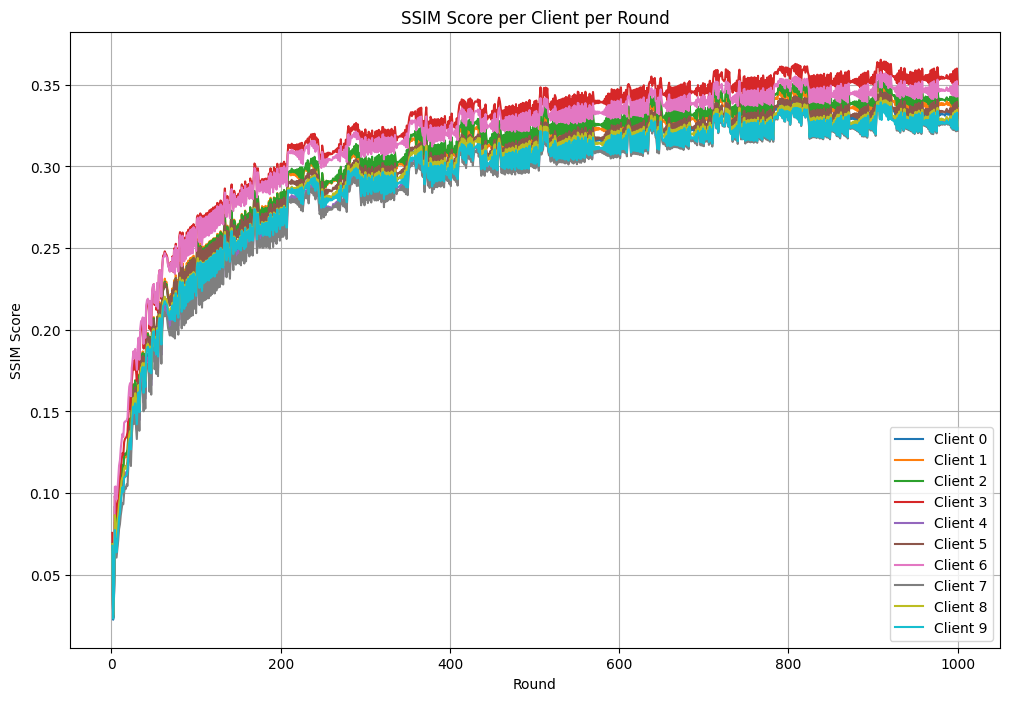

In [15]:
import matplotlib.pyplot as plt

def plot_ssim_scores(file_path: str):
    """Plot the SSIM scores of each client per round using the saved values."""
    round_times = []
    round_numbers = []
    client_ssim = {}

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('Time'):
                parts = line.split(' - ')
                round_times.append(parts[1])
                round_numbers.append(int(parts[1].split()[1]))
            else:
                client_id, ssim_score = line.split()
                if client_id not in client_ssim:
                    client_ssim[client_id] = []
                client_ssim[client_id].append(float(ssim_score))

    # Plotting
    plt.figure(figsize=(12, 8))
    for client_id, ssim_scores in client_ssim.items():
        plt.plot(round_numbers, ssim_scores, label=f'Client {client_id}')

    plt.xlabel('Round')
    plt.ylabel('SSIM Score')
    plt.title('SSIM Score per Client per Round')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_ssim_scores('ssim_scores.ncol')

Image: 032.jpeg
Anomaly: False, Loss: 398.1902, Threshold: 500.0000


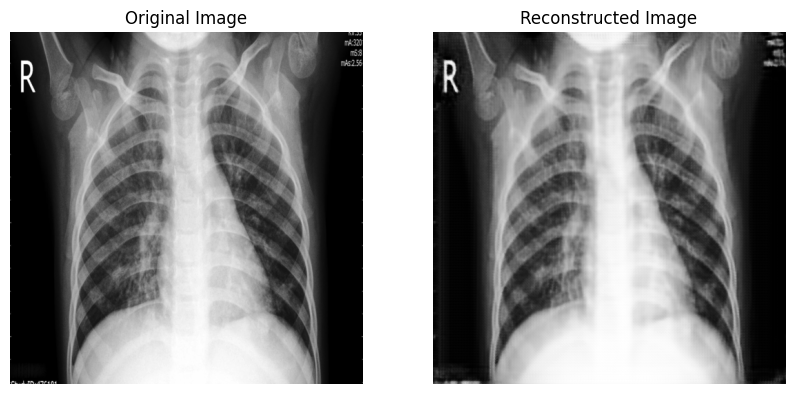

In [34]:
import os
import random
import torch
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the model and anomaly detection functions
def load_model(model_path):
    net = SparseAutoencoder()
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))  # Load the state dictionary
    net.load_state_dict(state_dict)  # Load the state dictionary into the model
    net.eval()
    return net

def check_anomaly(image_path, model, threshold):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        reconstructed = model(image)

    loss = F.mse_loss(reconstructed, image, reduction='sum').item()

    is_anomaly = loss > threshold
    return is_anomaly, loss, image, reconstructed

# Function to pick a random image from the directory and check for anomaly
def check_random_image(directory, model, threshold=0.01):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(directory, random_image_file)

    is_anomaly, loss, original_image, reconstructed_image = check_anomaly(random_image_path, model, threshold)

    print(f"Image: {random_image_file}")
    print(f"Anomaly: {is_anomaly}, Loss: {loss:.4f}, Threshold: {threshold:.4f}")

    # Display the original and reconstructed images
    original_image = original_image.squeeze().cpu().numpy()
    reconstructed_image = reconstructed_image.squeeze().cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Image')
    plt.imshow(reconstructed_image, cmap='gray')
    plt.axis('off')

    plt.show()

# Example usage:
model_path = 'latest_model.pth'
directory = 'Viral'
model = load_model(model_path)
check_random_image(directory, model, threshold=500)